In [2]:
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV, SGDRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from planet.app import Planet

In [ ]:
archive = Path('data/export.csv')
index = np.arange(0, 160178, 1)  # количество индексов = количеству строк в файле

quacke_df = pd.read_csv(archive, index_col=False, encoding='windows-1251', sep=';')

non_data = ['Дата', 'Час', 'Мин', 'Сек', 'Ошибка по времени', 'Ошибка по широте', 'Ошибка по долготе', 'Ошибка по глубине', 'Глубина', 'Код сети', 'Сейсмический регион', 'Географический регион', 'Макросейсмические данные']

In [ ]:
def add_param(frame):
    frame['Долгота'] = float(frame['Долгота'].replace(',', '.'))
    frame['Широта'] = float(frame['Широта'].replace(',', '.'))
    date = frame['Дата']
    frame['Магнитуда'] = float(frame['Магнитуда'].replace(',', '.')) 

    planet = Planet(frame['Долгота'], frame['Широта'], date)

    return pd.concat([frame, pd.Series(planet.get_parametrs())])

In [ ]:
quacke_df = quacke_df.apply(add_param, axis=1)

quacke_df = quacke_df.drop(non_data, axis=1)
quacke_df = quacke_df.dropna()

quacke_df.info()
quacke_df.to_csv('data/quacke.csv', index=False)

In [4]:
quacke_df = pd.read_csv('data/quacke.csv')

In [5]:
target_column = 'Магнитуда'
y = quacke_df[target_column]
X = quacke_df.drop(target_column, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Создаем набор моделей регресии для проверки

In [ ]:
models = []

# модель линейной регрессии
liner_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
liner_param = {}
models.append((liner_model, liner_param))

# модель RidgeCV
ridge_model = RidgeCV(cv=5)
ridge_param = {
    'alphas': [(5,10,20),(10,20,50),(15,40,90)],
}
models.append((ridge_model, ridge_param))

# модель LassoCV
lasso_model = LassoCV(cv=5)
lasso_param = {
    'max_iter': [20, 50, 100],
}
models.append((lasso_model, lasso_param))

# модель опороных векторов
svr_model = SVR(max_iter=1000)
svr_param = {
    'C': [350,400,450]
}
models.append((svr_model, svr_param))

# модель деревья решений
dtr_model = DecisionTreeRegressor()
dtr_param = {
    'max_depth': [5, 7, 10],
}
models.append((dtr_model, dtr_param))

# модель стахастический градиентный спуск
sgd_model = SGDRegressor()
sgd_param = {
    'penalty': ['l1', 'l2'],
    'alpha': [100, 150, 200],
}
models.append((sgd_model, sgd_param))

# модель случайный лес
rfr_model = RandomForestRegressor()
rfr_param = {
    'n_estimators': [20, 30, 40],
}
models.append((rfr_model, rfr_param))

#
gbr_model = GradientBoostingRegressor()
gbr_param ={
    'n_estimators': [30,40,50,90],
    'max_features': [30,40, 50],
}
models.append((gbr_model, gbr_param))


In [ ]:
def find_param(model, param):
    print(f'start train model {model}')    
    svc_grid = GridSearchCV(model, param)
    svc_grid.fit(X_train[:2500], y_train[:2500])
    score = svc_grid.score(X_test[:400], y_test[:400])
    return svc_grid.best_estimator_, score
    

results = []
for model_data in models[7:]:
    results.append(find_param(model_data[0], model_data[1]))

results

### Настройка моделей по оптимальным праметрам

In [ ]:
estimators = []

liner_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
ridge_model = RidgeCV(alphas=(5, 10, 20), cv=5)
lasso_model = LassoCV(cv=5, max_iter=50)
svr_model = SVR(C=350, max_iter=1000)
dtr_model = DecisionTreeRegressor(max_depth=5)
sgd_model = SGDRegressor(alpha=200)
rfr_model = RandomForestRegressor(n_estimators=40)
gbr_model = GradientBoostingRegressor(max_features=50, min_samples_split=5, n_estimators=90)

estimators = [liner_model, ridge_model, lasso_model, svr_model, dtr_model, sgd_model, rfr_model, gbr_model]

### Поиск лучших моделей на всей выборке

In [ ]:
models_score = pd.DataFrame(columns=['name', 'score'])
models_score.loc[0] = {
    'name': liner_model,
    'score': 0.8,
}
models_score

In [ ]:
models_score = pd.DataFrame(columns=['name', 'score'])

for num, model in enumerate(estimators):
    print(f'start train - {model}')
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    models_score.loc[num] = {'name': model,'score': model.score(X_test, y_test)}

models_score.sort_values(by='score', ascending=False)

## Ансамбли

### Создание комбинаций estimators

In [ ]:
best_estimators = [estimators[6],estimators[7],estimators[4],estimators[0],estimators[1],estimators[2]]
import itertools

est_list = []
for comb in itertools.combinations(best_estimators, 2):
    comb = list(comb)
    est_list.append([('mod1', comb[0]), ('mod2', comb[1])])

print(len(est_list))
est_list


### StackingRegressor

In [ ]:
stacking_result = pd.DataFrame(columns=['comb_ind', 'score'])

In [ ]:
for num, estimators in enumerate(est_list):
    print(f'start estimators = {estimators}')
    ensemble_model = StackingRegressor(estimators=estimators, final_estimator=RidgeCV(alphas=(0.1, 1, 10)))
    ensemble_model.fit(X_train[:8000], y_train[:8000])
    stacking_result.loc[num] = {'comb_ind': num, 'score': ensemble_model.score(X_test[:800], y_test[:800])}

stacking_result.sort_values(by='score', ascending=False)

Меняем final_estimator

In [ ]:
for num, estimators in enumerate(est_list):
    print(f'start estimators = {estimators}')
    ensemble_model = StackingRegressor(estimators=estimators, final_estimator=make_pipeline(PolynomialFeatures(degree=2), LinearRegression()))
    ensemble_model.fit(X_train[:8000], y_train[:8000])
    stacking_result.loc[num+15] = {'comb_ind': num, 'score': ensemble_model.score(X_test[:800], y_test[:800])}

stacking_result.sort_values(by='score', ascending=False)[:7]

Меняем final_estimator lasso

In [ ]:
for num, estimators in enumerate(est_list):
    print(f'start estimators = {estimators}')
    ensemble_model = StackingRegressor(estimators=estimators, final_estimator=LassoCV(cv=5))
    ensemble_model.fit(X_train[:8000], y_train[:8000])
    stacking_result.loc[num+30] = {'comb_ind': num, 'score': ensemble_model.score(X_test[:800], y_test[:800])}

stacking_result.sort_values(by='score', ascending=False)[:10]

In [ ]:
stacking_result.sort_values(by='score', ascending=False)[:11]

In [ ]:
best_est_stack_ridge = [est_list[0], est_list[7], est_list[8], est_list[6]]
best_est_stack_ridge

In [ ]:
bagging_result = pd.DataFrame(columns=['comb_ind', 'score'])

In [ ]:
estimators

In [ ]:
for num, estimator in enumerate(estimators):
    print(f'start estimators = {estimator}')
    ensemble_model = BaggingRegressor(estimator=estimator)
    ensemble_model.fit(X_train[:8000], y_train[:8000])
    bagging_result.loc[num+30] = {'comb_ind': num, 'score': ensemble_model.score(X_test[:800], y_test[:800])}

bagging_result.sort_values(by='score', ascending=False)[:10]

In [ ]:
best_estimators = [
    ('gbr', GradientBoostingRegressor(max_features=50, min_samples_split=5, n_estimators=90)),
    ('rfr', RandomForestRegressor(n_estimators=40)),
    ('lr', make_pipeline(PolynomialFeatures(degree=2), LinearRegression())),
]

ensemble_model = StackingRegressor(estimators=best_estimators, final_estimator=RidgeCV(alphas=(0.1, 1, 10)))
ensemble_model.fit(X_train, y_train)

ensemble_model.score(X_test, y_test)


### Расчет точности предсказаний

Линейная модель показывает хорошую точность только на имеющхся данных, будующие прогнозы крайне неточные (в том числе отрицательные значения)

In [7]:
ensemble_model = joblib.load('models/ensemble_model.pkl')

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
y_pred = ensemble_model.predict(X_test)

ridge_score = ensemble_model.score(X_test, y_test)
med_ae = median_absolute_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=False)
cvs = cross_val_score(ensemble_model, X_test, y_test, cv=3).mean()
message = """Коэфициент детерминации - {0},\n
Средняя абсолютная ошибка - {1},\n
Среднее абсолютное отклонение - {2},\n
Среднеквадратичное отклонение - {3},\n
Перекрестная проверка - {4},\n 
""".format(ridge_score, med_ae, mae, mse, cvs)
print(message)

Коэфициент детерминации - 0.5874646169214544,

Средняя абсолютная ошибка - 0.3347043019073299,

Среднее абсолютное отклонение - 0.4314005092847357,

Среднеквадратичное отклонение - 0.587678269973609,

Перекрестная проверка - 0.554500157088776,
 



In [16]:
X_test[y_test > 5]

,Широта,Долгота,Mercury_earth_distance,Mercury_sun_distance,Mercury_hlat,Mercury_hlon,Mercury_size,Mercury_radius,Mercury_a_ra,Mercury_elong,...,Moon_a_ra,Moon_elong,Sun_earth_distance,Sun_sun_distance,Sun_hlat,Sun_hlon,Sun_size,Sun_radius,Sun_a_ra,Sun_elong
121807,53.759,160.746,117.233331,49.884229,0.122005,2.352357,8.600708,0.000021,4.395002,-0.304877,...,5.457800,0.703584,147.169096,0.0,-1.716308e-06,1.576535,1950.935181,0.004729,4.713868,0.0
144437,47.300,155.690,205.538478,54.983558,0.109095,2.888882,4.905600,0.000012,2.875754,0.032946,...,4.129313,1.328262,150.863011,0.0,-3.238361e-08,5.972000,1903.166138,0.004613,2.850169,0.0
7355,53.010,160.430,167.279260,61.957220,-0.122219,5.530200,6.027584,0.000015,4.428957,0.376361,...,4.922938,0.819752,147.942827,0.0,2.506174e-06,0.942138,1940.731812,0.004704,4.041052,0.0
9659,55.280,166.910,123.502602,68.465865,-0.014078,4.101098,8.164117,0.000020,2.379680,0.457919,...,2.611685,0.670056,152.092753,0.0,-1.929635e-06,5.024055,1887.778076,0.004576,1.907044,0.0
59357,49.048,156.638,160.035988,46.237207,0.031786,1.107794,6.300393,0.000015,6.220464,0.291191,...,0.971069,1.369942,148.197649,0.0,-1.483967e-06,2.789123,1937.394897,0.004696,5.954933,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24413,46.510,152.610,184.387215,55.868525,-0.108765,6.033948,5.468327,0.000013,5.361998,0.253282,...,5.625306,0.517326,147.118734,0.0,4.084596e-07,1.922065,1951.602905,0.004731,5.090311,0.0
17460,46.112,154.517,111.693020,46.058890,0.071987,1.472152,9.027329,0.000022,3.804601,-0.220836,...,2.937408,-1.140591,147.992324,0.0,4.516179e-08,0.915924,1940.082764,0.004703,4.013795,0.0
43825,52.190,142.410,201.508634,53.040322,-0.090782,0.011308,5.003704,0.000012,6.237315,0.034071,...,6.195275,0.084996,148.799413,0.0,-1.470482e-06,3.059444,1929.559814,0.004677,6.205503,0.0
98413,43.200,146.660,214.790725,69.710832,-0.070701,4.602657,4.694289,0.000011,4.350357,0.104220,...,1.615227,-2.658963,147.598775,0.0,2.065441e-06,1.141832,1945.255737,0.004715,4.245852,0.0


In [22]:
y_pred = ensemble_model.predict(X_test)
y_pred[y_pred > 5]

array([5.14421489, 5.22373137, 5.21896883, 5.13262855, 5.10344108])

In [19]:
crop = 200

x = np.arange(1, len(y_test_1)+1,1)[:crop]
pic_y_test = y_test_1[:crop].set_axis(x)
pic_y_lin = pd.Series(y_pred[:crop]).set_axis(x)

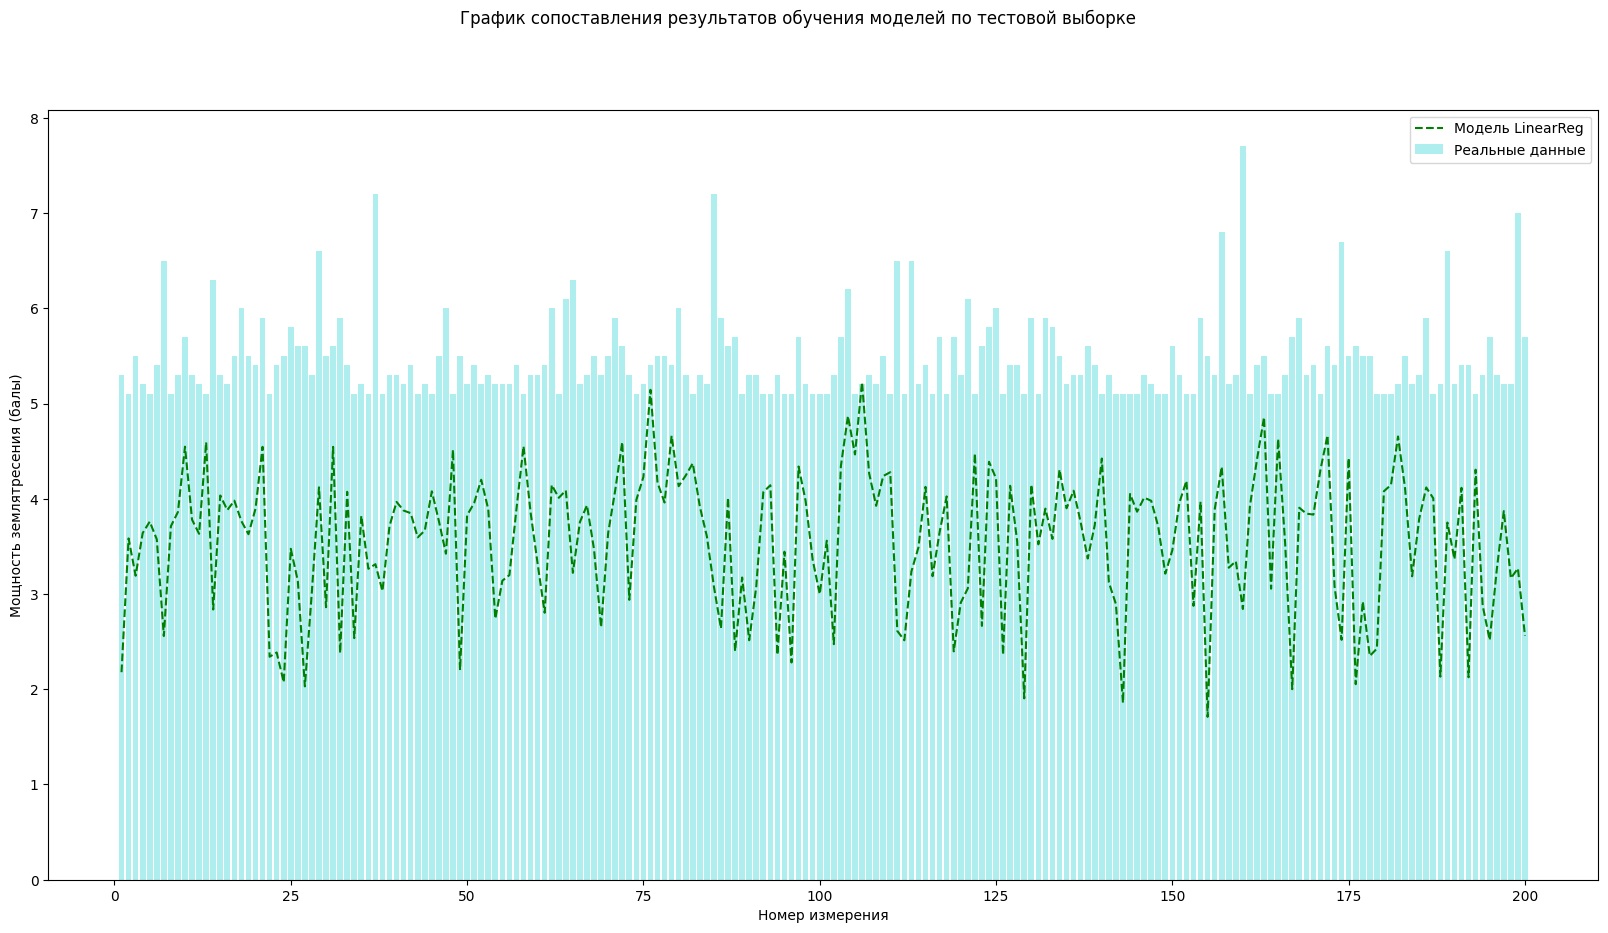

In [20]:
plt.figure(figsize=(20,10))
plt.suptitle('График сопоставления результатов обучения моделей по тестовой выборке')

plt.bar(x, pic_y_test,label='Реальные данные', color='#AFEEEE')
plt.plot(pic_y_lin, '--', color='g', label='Модель LinearReg')

plt.xlabel('Номер измерения')
plt.ylabel('Мощность землятресения (балы)')
plt.legend(loc='best')

plt.show()

In [ ]:
joblib.dump(ensemble_model, 'models/ensemble_model.pkl')
